In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import gluonts
from gluonts.dataset import common
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.util import to_pandas
from gluonts.evaluation import make_evaluation_predictions
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.Configuration import Configuration
from PythonFiles.model import model, preprocessing, make_one_ts_prediction

config = Configuration()
df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/influenza.csv", sep=',')
df.head()

,Unnamed: 0.1,Unnamed: 0,year,date,week,age_group,location,value
0,28095,0,2004,2004-01-04,1,00+,LK Ahrweiler,0.0
1,28096,1,2004,2004-01-11,2,00+,LK Ahrweiler,0.0
2,28097,2,2004,2004-01-18,3,00+,LK Ahrweiler,0.0
3,28098,3,2004,2004-01-25,4,00+,LK Ahrweiler,2.0
4,28099,4,2004,2004-02-01,5,00+,LK Ahrweiler,0.0


## Only looking at one Time Series (i.e. only one location)

In [2]:
one_ts_df = df.loc[df.location == "LK Bad Dürkheim", ["value", 'location', 'date']]
one_ts_df = preprocessing(config, one_ts_df, check_count=False, output_type="corrected_df")
one_ts_df

,value,location
2010-01-03,1.0,LK Bad Dürkheim
2010-01-10,1.0,LK Bad Dürkheim
2010-01-17,0.0,LK Bad Dürkheim
2010-01-24,0.0,LK Bad Dürkheim
2010-01-31,0.0,LK Bad Dürkheim
...,...,...
2019-12-01,0.0,LK Bad Dürkheim
2019-12-08,1.0,LK Bad Dürkheim
2019-12-15,1.0,LK Bad Dürkheim
2019-12-22,1.0,LK Bad Dürkheim


In [3]:
train_set = one_ts_df.loc[(one_ts_df.index <= config.test_end_time) &
                          (one_ts_df.index >= config.train_start_time), :]
test_set = one_ts_df.loc[(one_ts_df.index >= config.train_start_time) &
                         (one_ts_df.index <= config.test_end_time), :]
window_dates = []
for window in range(1, config.windows+1):
    unique_weeks = test_set.index.unique()
    selected_split_week = unique_weeks[-window*config.prediction_length : -window*config.prediction_length + 1]
    window_dates.append(datetime(selected_split_week.year[0],
                                 selected_split_week.month[0],
                                 selected_split_week.day[0]))
    
test_windows = [test_set.loc[test_set.index < window_date, :] for window_date in window_dates]

train_set = PandasDataset.from_long_dataframe(dataframe=train_set,
                                              item_id='location',
                                              target="value",
                                              freq=config.freq)
test_set = PandasDataset(test_windows,
                         target="value",
                         freq=config.freq)

In [4]:
forecasts, tss = model(config, train_set, test_set, config.deeparestimator)

100%|██████████| 50/50 [00:09<00:00,  5.41it/s, epoch=4/4, avg_epoch_loss=0.791]


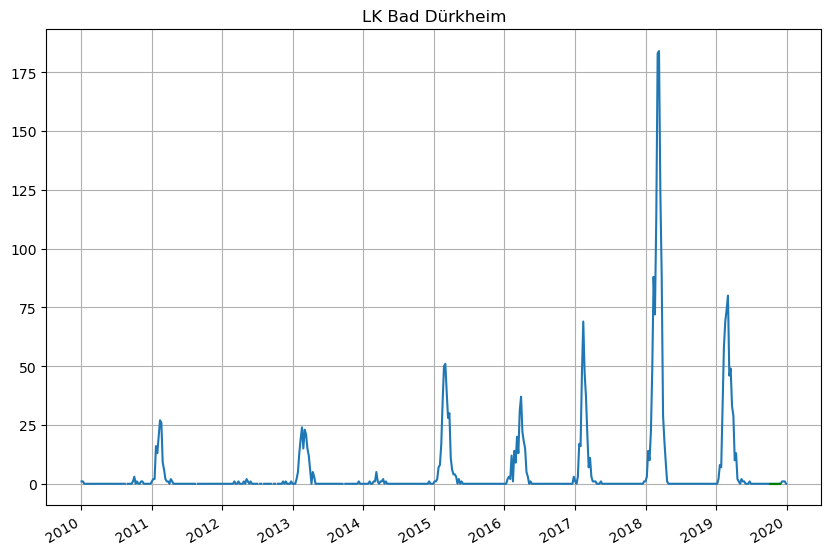

In [5]:
locations = [x for x in one_ts_df.loc[:, 'location'].unique()]
start = one_ts_df.loc[(one_ts_df.index >= config.train_start_time)].index[0]
test_data = common.ListDataset([{"start": start,
                                 "target": one_ts_df.loc[(one_ts_df.index <= config.test_end_time) &
                                                         (one_ts_df.index >= config.train_start_time) &
                                                         (one_ts_df.location == x), config.target]}
                                for x in one_ts_df.loc[: , 'location'].unique()], freq=config.freq)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.title(f'{locations[0]}')
plt.plot((one_ts_df.loc[(one_ts_df['location'] == str(locations[0])) &
                        (one_ts_df.index <= config.test_end_time) &
                        (one_ts_df.index >= config.train_start_time)].index),
         one_ts_df.loc[(one_ts_df['location'] == str(locations[0])) &
                       (one_ts_df.index <= config.test_end_time) &
                       (one_ts_df.index >= config.train_start_time), 'value'])
plt.grid(which="both")
color = ["g", "r"]
for k in [0, 1]:
    forecast_entry = forecasts[k]
    prediction_intervals = (50.0, 90.0)
    legend = ["train_set observations", "median prediction"] \
             + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    forecast_entry.plot(prediction_intervals=prediction_intervals, color=color)
    plt.grid(which="both")
plt.show()

## Using a function based on the previous cells

100%|██████████| 50/50 [00:10<00:00,  4.85it/s, epoch=4/4, avg_epoch_loss=0.646]


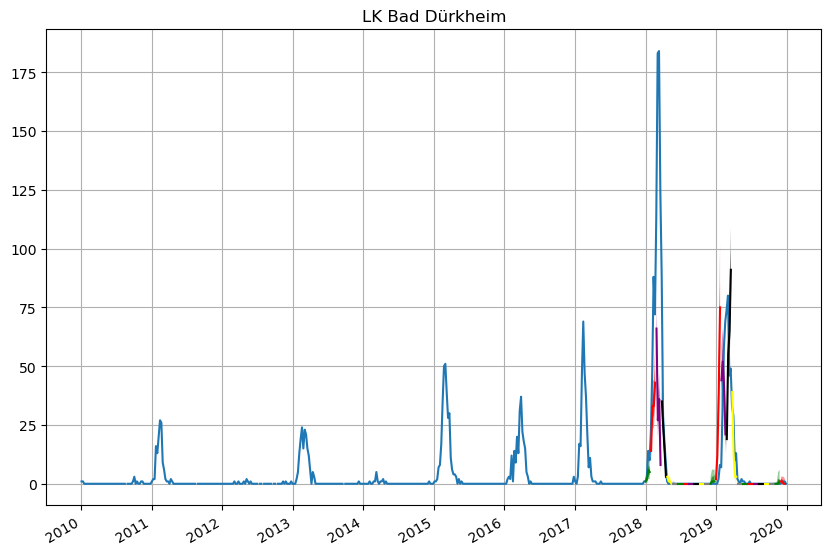

In [6]:
forecasts, tss = make_one_ts_prediction(config, df, location="LK Bad Dürkheim")

100%|██████████| 50/50 [00:20<00:00,  2.40it/s, epoch=4/4, avg_epoch_loss=0.823]


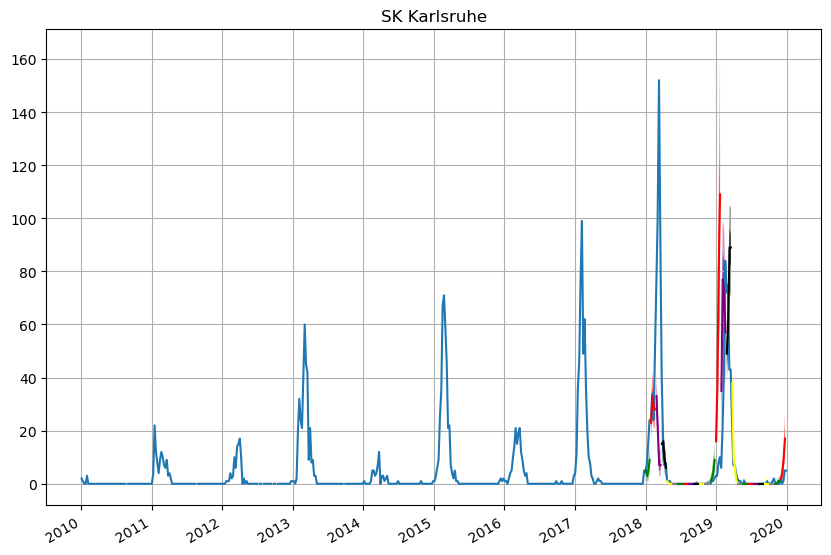

In [7]:
forecasts, tss = make_one_ts_prediction(config, df, location="SK Karlsruhe")

100%|██████████| 50/50 [00:24<00:00,  2.01it/s, epoch=4/4, avg_epoch_loss=-.0944]


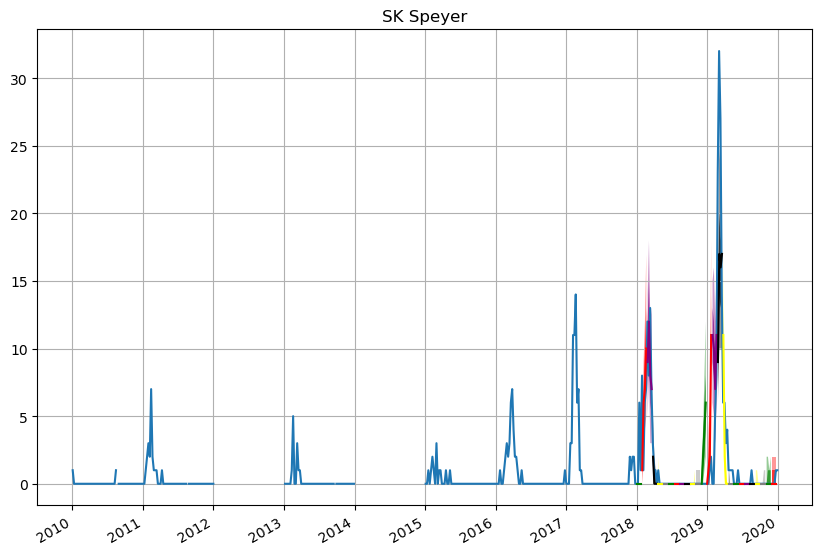

In [8]:
forecasts, tss = make_one_ts_prediction(config, df, location="SK Speyer")